In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
####读取数据
import os
from scipy import stats

In [178]:
os.chdir(r"E:\data\国防科大合作项目\untitled-master\True_40")
true_pl = []
for f in os.listdir(r"E:\data\国防科大合作项目\untitled-master\True_40"):
    df = pd.read_csv(f)
    
    fdj = df["发动机转速"].mean()
    
    bs = df[(df["泵车状态"]==1)|(df["泵车状态"]==3)]
    bs30 = len(bs[(bs["泵送排量"]>25)&(bs["泵送排量"]<35)])
    bs70 = len(bs[(bs["泵送排量"]>65)&(bs["泵送排量"]<75)])
    bs100 = len(bs[(bs["泵送排量"]>95)])
    
    hx = df["转向次数"]
    hx_mean = hx.mean()
    hx_max = hx.max()
    hx_med = hx.median()
    
    yl = df['系统压力']
    yl_mean = yl.mean()
    yl_max = yl.max()
    yl_med = yl.median()
    
    zt = df["泵车状态"]
    zt_mod = zt.mode().values[0]
    bs_rate = len(zt[(zt==1)|(zt==3)]) / len(zt)
#     print(zt_mod)
    if zt_mod==1 or zt_mod==3:
        bs_flag = 1
    else:
        bs_flag = 0
    
    tmp = df["泵送排量"]
    max_ = tmp.max()
    min_ = tmp.min()
    median_ = tmp.median()
    mean_ = tmp.mean()
    
    L30 = len(tmp[(tmp>25)&(tmp<35)])
    L70 = len(tmp[(tmp>65)&(tmp<75)])
    L100 = len(tmp[(tmp>95)])
    
    tmp_diff = tmp - tmp.shift(24)  ###2min变化
    l_40 = len(tmp_diff[(tmp_diff>35) & (tmp_diff<45)])
    l_30 = len(tmp_diff[(tmp_diff>25) & (tmp_diff<35)])
    l_n55 = len(tmp_diff[tmp_diff<-55])
    
    true_pl.append([fdj,bs30,bs70,bs100,hx_mean,hx_max,hx_med, yl_mean,yl_max,yl_med, zt_mod,bs_rate,bs_flag,max_,min_,median_,mean_,L30,L70,L100,l_40,l_30,l_n55])

In [179]:
df_t = pd.DataFrame(true_pl)
df_t["label"] = 1

In [180]:
os.chdir(r"E:\data\国防科大合作项目\untitled-master\False_40")
true_pl = []
for f in os.listdir(r"E:\data\国防科大合作项目\untitled-master\False_40"):
#     print(f)
    df = pd.read_csv(f)
    
    fdj = df["发动机转速"].mean()
    
    bs = df[(df["泵车状态"]==1)|(df["泵车状态"]==3)]
    bs30 = len(bs[(bs["泵送排量"]>25)&(bs["泵送排量"]<35)])
    bs70 = len(bs[(bs["泵送排量"]>65)&(bs["泵送排量"]<75)])
    bs100 = len(bs[(bs["泵送排量"]>95)])
                   
    hx = df["转向次数"]
    hx_mean = hx.mean()
    hx_max = hx.max()
    hx_med = hx.median()
    
    yl = df['系统压力']
    yl_mean = yl.mean()
    yl_max = yl.max()
    yl_med = yl.median()
    
    zt = df["泵车状态"]
    zt_mod = zt.mode().values[0]
    bs_rate = len(zt[(zt==1)|(zt==3)]) / len(zt)
    if zt_mod==1 or zt_mod==3:
        bs_flag = 1
    else:
        bs_flag = 0
    
    
    tmp = df["泵送排量"]
    
    max_ = tmp.max()
    min_ = tmp.min()
    median_ = tmp.median()
    mean_ = tmp.mean()
    
    L30 = len(tmp[(tmp>25)&(tmp<35)])
    L70 = len(tmp[(tmp>65)&(tmp<75)])
    L100 = len(tmp[(tmp>95)])
    
    tmp_diff = tmp - tmp.shift(24)
    l_40 = len(tmp_diff[(tmp_diff>35) & (tmp_diff<45)])
    l_30 = len(tmp_diff[(tmp_diff>25) & (tmp_diff<35)])
    l_n55 = len(tmp_diff[tmp_diff<-55])
    
    true_pl.append([fdj,bs30,bs70,bs100,hx_mean,hx_max,hx_med, yl_mean,yl_max,yl_med, zt_mod,bs_rate,bs_flag,max_,min_,median_,mean_,L30,L70,L100,l_40,l_30,l_n55])
df_f = pd.DataFrame(true_pl)
df_f["label"] = 0

In [181]:
data = pd.concat([df_t,df_f])
data.drop(["label"],axis=1)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
data.drop(["label"],axis=1), data["label"], test_size=0.33, random_state=42)

In [10]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'cross_entropy'},
    "lambda_l1":0.3,
    "lambda_l2":0.3,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=3000,
                valid_sets=lgb_eval,
                early_stopping_rounds=50)

print('Saving model...')
# save model to file
# gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

Starting training...
[1]	valid_0's xentropy: 0.665596
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's xentropy: 0.641819
[3]	valid_0's xentropy: 0.619838
[4]	valid_0's xentropy: 0.600336
[5]	valid_0's xentropy: 0.582131
[6]	valid_0's xentropy: 0.565134
[7]	valid_0's xentropy: 0.54905
[8]	valid_0's xentropy: 0.534792
[9]	valid_0's xentropy: 0.521974
[10]	valid_0's xentropy: 0.509636
[11]	valid_0's xentropy: 0.498212
[12]	valid_0's xentropy: 0.48771
[13]	valid_0's xentropy: 0.478637
[14]	valid_0's xentropy: 0.469285
[15]	valid_0's xentropy: 0.460606
[16]	valid_0's xentropy: 0.452398
[17]	valid_0's xentropy: 0.444797
[18]	valid_0's xentropy: 0.43783
[19]	valid_0's xentropy: 0.431006
[20]	valid_0's xentropy: 0.425091
[21]	valid_0's xentropy: 0.419552
[22]	valid_0's xentropy: 0.414196
[23]	valid_0's xentropy: 0.409419
[24]	valid_0's xentropy: 0.405022
[25]	valid_0's xentropy: 0.400488
[26]	valid_0's xentropy: 0.396165
[27]	valid_0's xentropy: 0.391611
[28]	valid_

In [11]:
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred[0].apply(lambda x: 1 if x>0.5 else 0)

# eval
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))


The accuracy of prediction is: 0.855464759959142


In [182]:
import xgboost as xgb
from xgboost import XGBClassifier



model = XGBClassifier(objective='binary:logistic',min_child_weight=2,n_estimators =800,learning_rate=0.09,max_depth=4
                     )
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='auc',
        early_stopping_rounds = 40
       )
 
# 对测试集做预测
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
 
# 评估预测结果
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.5f%%" % (accuracy * 100.0))

[0]	validation_0-auc:0.894944	validation_1-auc:0.873931
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 40 rounds.
[1]	validation_0-auc:0.909685	validation_1-auc:0.884679
[2]	validation_0-auc:0.910391	validation_1-auc:0.884942
[3]	validation_0-auc:0.912086	validation_1-auc:0.885652
[4]	validation_0-auc:0.913482	validation_1-auc:0.886634
[5]	validation_0-auc:0.915667	validation_1-auc:0.889195
[6]	validation_0-auc:0.915436	validation_1-auc:0.889317
[7]	validation_0-auc:0.915626	validation_1-auc:0.889026
[8]	validation_0-auc:0.916825	validation_1-auc:0.890609
[9]	validation_0-auc:0.918232	validation_1-auc:0.89393
[10]	validation_0-auc:0.918695	validation_1-auc:0.89418
[11]	validation_0-auc:0.921055	validation_1-auc:0.896171
[12]	validation_0-auc:0.922886	validation_1-auc:0.897959
[13]	validation_0-auc:0.924529	validation_1-auc:0.899395
[14]	validation_0-auc:0.925252	validation_1-auc:0.900147


[141]	validation_0-auc:0.977142	validation_1-auc:0.927038
[142]	validation_0-auc:0.977233	validation_1-auc:0.92693
[143]	validation_0-auc:0.977292	validation_1-auc:0.926999
[144]	validation_0-auc:0.977403	validation_1-auc:0.927147
[145]	validation_0-auc:0.977459	validation_1-auc:0.927186
[146]	validation_0-auc:0.977501	validation_1-auc:0.927187
[147]	validation_0-auc:0.977837	validation_1-auc:0.927568
[148]	validation_0-auc:0.977958	validation_1-auc:0.92726
[149]	validation_0-auc:0.978285	validation_1-auc:0.927223
[150]	validation_0-auc:0.978424	validation_1-auc:0.92729
[151]	validation_0-auc:0.97845	validation_1-auc:0.927368
[152]	validation_0-auc:0.978698	validation_1-auc:0.927203
[153]	validation_0-auc:0.978719	validation_1-auc:0.927156
[154]	validation_0-auc:0.978951	validation_1-auc:0.927214
[155]	validation_0-auc:0.978998	validation_1-auc:0.927299
[156]	validation_0-auc:0.979158	validation_1-auc:0.927201
[157]	validation_0-auc:0.979225	validation_1-auc:0.927254
[158]	validation_0

In [183]:
model.save_model("xgb_bst.model")

In [189]:
model.feature_importances_

array([0.02123375, 0.02546174, 0.18436393, 0.01500497, 0.01957744,
       0.02386435, 0.05588821, 0.02259159, 0.02595852, 0.05419376,
       0.        , 0.24188955, 0.        , 0.        , 0.01945314,
       0.01685456, 0.03082359, 0.02692234, 0.07219841, 0.03201206,
       0.05224978, 0.01541787, 0.04404042], dtype=float32)

In [212]:
model.feature_importances_??

In [210]:
b = model.get_booster()
score = b.get_score()
all_features = [score.get(f, 0.) for f in b.feature_names]
all_features = np.array(all_features, dtype=np.float32)

In [213]:
all_features / all_features.sum()

array([0.08458921, 0.03548858, 0.05444822, 0.03257171, 0.06028197,
       0.05007292, 0.0563928 , 0.08604764, 0.05104521, 0.0802139 ,
       0.        , 0.0617404 , 0.        , 0.        , 0.02916869,
       0.00875061, 0.06806028, 0.02771026, 0.02430724, 0.04423918,
       0.03014098, 0.04132231, 0.07340787], dtype=float32)

In [211]:
all_features

array([174.,  73., 112.,  67., 124., 103., 116., 177., 105., 165.,   0.,
       127.,   0.,   0.,  60.,  18., 140.,  57.,  50.,  91.,  62.,  85.,
       151.], dtype=float32)

In [207]:
s

{'11': 127,
 '20': 62,
 '6 ': 116,
 '22': 151,
 '5 ': 103,
 '0 ': 174,
 '19': 91,
 '16': 140,
 '2 ': 112,
 '9 ': 165,
 '7 ': 177,
 '1 ': 73,
 '17': 57,
 '4 ': 124,
 '8 ': 105,
 '18': 50,
 '15': 18,
 '21': 85,
 '14': 60,
 '3 ': 67}

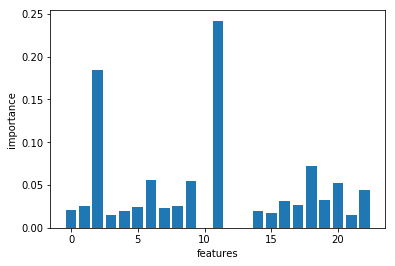

In [193]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xlabel("features")
plt.ylabel("importance")
plt.savefig("xgb_feature_importance.png",dpi=500)

In [214]:
xgb.plot_importance??

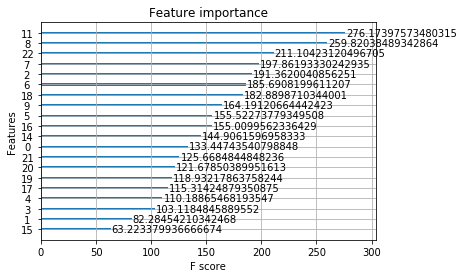

In [216]:
xgb.plot_importance(model,importance_type="cover")

In [33]:
dtrain = xgb.DMatrix(X_train,  label=y_train)
dtest = xgb.DMatrix(X_test,  label=y_test)
param = {'max_depth':6, 'eta':1, 'silent':1, 'objective':'binary:logistic','min_child_weight':2}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 150
bst = xgb.train(param, dtrain, num_round, watchlist,early_stopping_rounds=15)

[0]	eval-error:0.172114	train-error:0.133082
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 15 rounds.
[1]	eval-error:0.162411	train-error:0.127044
[2]	eval-error:0.157303	train-error:0.11522
[3]	eval-error:0.157303	train-error:0.10717
[4]	eval-error:0.152196	train-error:0.099119
[5]	eval-error:0.149132	train-error:0.088553
[6]	eval-error:0.160368	train-error:0.079497
[7]	eval-error:0.162921	train-error:0.072453
[8]	eval-error:0.170582	train-error:0.067673
[9]	eval-error:0.168029	train-error:0.067673
[10]	eval-error:0.165986	train-error:0.066667
[11]	eval-error:0.164964	train-error:0.061887
[12]	eval-error:0.164964	train-error:0.053585
[13]	eval-error:0.171093	train-error:0.051572
[14]	eval-error:0.166496	train-error:0.052075
[15]	eval-error:0.167518	train-error:0.048302


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16]	eval-error:0.170071	train-error:0.04478
[17]	eval-error:0.173136	train-error:0.042264
[18]	eval-error:0.170582	train-error:0.040503
[19]	eval-error:0.172625	train-error:0.039245
[20]	eval-error:0.175179	train-error:0.036226
[21]	eval-error:0.175179	train-error:0.03195
[22]	eval-error:0.175689	train-error:0.031447
[23]	eval-error:0.175689	train-error:0.031447
[24]	eval-error:0.174157	train-error:0.025912
[25]	eval-error:0.173136	train-error:0.025157
[26]	eval-error:0.175689	train-error:0.023899
[27]	eval-error:0.174668	train-error:0.022138
[28]	eval-error:0.174668	train-error:0.020126
[29]	eval-error:0.174157	train-error:0.018868
[30]	eval-error:0.172114	train-error:0.016855
[31]	eval-error:0.174157	train-error:0.014843
[32]	eval-error:0.175689	train-error:0.013585
[33]	eval-error:0.175689	train-error:0.013082
[34]	eval-error:0.174668	train-error:0.010818
[35]	eval-error:0.1762	train-error:0.009811
[36]	eval-error:0.179265	train-error:0.008302
[37]	eval-error:0.177732	train-error:0

In [34]:
# 对测试集做预测
y_pred = bst.predict(xgb.DMatrix(X_test))
predictions = [round(value) for value in y_pred]
 
# 评估预测结果

accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 82.63534%


In [120]:
##GRU

In [172]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import GRU,Bidirectional
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical

In [103]:
os.chdir(r"E:\data\国防科大合作项目\untitled-master\False_40")
false_pl = []
for f in os.listdir(r"E:\data\国防科大合作项目\untitled-master\False_40"):
    print(f)
    df = pd.read_csv(f)
    df = df[["泵车状态","累计时间","液压油温","发动机转速","泵送排量","转向次数","系统压力","累计油耗"]]
    
    df["is_state3or1"] = df["泵车状态"].apply(lambda x: 1 if x==3 or x==1 else 0 )
#     df["is_state1"] = df["泵车状态"].apply(lambda x: 1 if x==1 else 0 )
    false_pl.append(df)


false2_ascend119BC5333275314243.csv
false2_ascend119BC5333275314279.csv
false2_ascend119BC5333275314315.csv
false2_ascend119BC5333275314351.csv
false2_ascend119BC5333275314387.csv
false2_ascend119BC5333275314566.csv
false2_ascend119BC5333275314602.csv
false2_ascend119BC5333275314638.csv
false2_ascend119BC5333275314674.csv
false2_ascend119BC5333275314710.csv
false2_ascend119BC5333275314746.csv
false2_ascend119BC5333275314782.csv
false2_ascend119BC5333275314818.csv
false2_ascend119BC5333275314854.csv
false2_ascend119BC5333275314890.csv
false2_ascend119BC5333275314926.csv
false2_ascend119BC5333275314962.csv
false2_ascend119BC5333275314998.csv
false2_ascend119BC5333275315034.csv
false2_ascend119BC5333307521019.csv
false2_ascend119BC5333307521055.csv
false2_ascend119BC5333307521091.csv
false2_ascend119BC5333307521127.csv
false2_ascend119BC5333307521163.csv
false2_ascend119BC5333307521199.csv
false2_ascend119BC5333307521235.csv
false2_ascend119BC5333307521271.csv
false2_ascend119BC5333307521

false2_ascend19BC5340312123692.csv
false2_ascend19BC5340312123728.csv
false2_ascend19BC5340312123764.csv
false2_ascend19BC5340322814317.csv
false2_ascend19BC5340322814341.csv
false2_ascend19BC5340322814365.csv
false2_ascend19BC5340322814389.csv
false2_ascend19BC5340322814413.csv
false2_ascend19BC5340322814616.csv
false2_ascend19BC5340322814652.csv
false2_ascend19BC5340322814688.csv
false2_ascend19BC5340322814724.csv
false2_ascend19BC5340322814760.csv
false2_ascend19BC5340322814796.csv
false2_ascend19BC5340322814832.csv
false2_ascend19BC5340322814868.csv
false2_ascend19BC5340322814904.csv
false2_ascend19BC5340322814940.csv
false2_ascend19BC5340322814976.csv
false2_ascend19BC5340322815012.csv
false2_ascend19BC5340322815048.csv
false2_ascend19BC5340322815084.csv
false2_ascend19BC534032585419.csv
false2_ascend19BC534032585455.csv
false2_ascend19BC534032585491.csv
false2_ascend19BC534032585527.csv
false2_ascend19BC534032585563.csv
false2_ascend19BC534032585599.csv
false2_ascend19BC534032585

false2_ascend19BC5440276211891.csv
false2_ascend19BC5440276211927.csv
false2_ascend19BC5440276211963.csv
false2_ascend19BC5440276211999.csv
false2_ascend19BC5440276212035.csv
false2_ascend19BC5440276212071.csv
false2_ascend19BC5440276212107.csv
false2_ascend19BC5440276212143.csv
false2_ascend19BC5440276212179.csv
false2_ascend19BC5440276212215.csv
false2_ascend19BC5440276212251.csv
false2_ascend19BC5440281559623.csv
false2_ascend19BC5440281559659.csv
false2_ascend19BC5440281559695.csv
false2_ascend19BC5440281559731.csv
false2_ascend19BC5440281559767.csv
false2_ascend19BC5440281559803.csv
false2_ascend19BC5440281559839.csv
false2_ascend19BC5440281559875.csv
false2_ascend19BC5440281559911.csv
false2_ascend19BC5440281559947.csv
false2_ascend19BC5440281559983.csv
false2_ascend19BC5440281560019.csv
false2_ascend19BC5440281560055.csv
false2_ascend19BC5440281560091.csv
false2_ascend19BC5440281912955.csv
false2_ascend19BC5440281912979.csv
false2_ascend19BC5440281913003.csv
false2_ascend19BC544

false2_ascend19BC544725955680.csv
false2_ascend19BC544725955704.csv
false2_ascend19BC544725955728.csv
false2_ascend19BC544725955752.csv
false2_ascend19BC544725955776.csv
false2_ascend19BC544725955979.csv
false2_ascend19BC544725956015.csv
false2_ascend19BC544725956051.csv
false2_ascend19BC544725956087.csv
false2_ascend19BC544725956123.csv
false2_ascend19BC544725956159.csv
false2_ascend19BC544725956195.csv
false2_ascend19BC544725956231.csv
false2_ascend19BC544725956267.csv
false2_ascend19BC544725956303.csv
false2_ascend19BC544725956339.csv
false2_ascend19BC544725956375.csv
false2_ascend19BC544725956411.csv
false2_ascend19BC544725956447.csv
false2_ascend19BC5449298394438.csv
false2_ascend19BC5449298394474.csv
false2_ascend19BC5449298394510.csv
false2_ascend19BC5449298394546.csv
false2_ascend19BC5449298394582.csv
false2_ascend19BC5449298394618.csv
false2_ascend19BC5449298394654.csv
false2_ascend19BC5449298394690.csv
false2_ascend19BC5449298394726.csv
false2_ascend19BC5449298394762.csv
fals

false2_ascend19BC5449309015916.csv
false2_ascend19BC5449309015952.csv
false2_ascend19BC544930934987.csv
false2_ascend19BC544930935023.csv
false2_ascend19BC544930935059.csv
false2_ascend19BC544930935095.csv
false2_ascend19BC544930935131.csv
false2_ascend19BC544930935167.csv
false2_ascend19BC544930935203.csv
false2_ascend19BC544930935239.csv
false2_ascend19BC544930935275.csv
false2_ascend19BC544930935311.csv
false2_ascend19BC544930935347.csv
false2_ascend19BC544930935383.csv
false2_ascend19BC544930935419.csv
false2_ascend19BC544930935455.csv
false2_ascend19BC5449309513594.csv
false2_ascend19BC5449309513630.csv
false2_ascend19BC5449309513666.csv
false2_ascend19BC5449309513702.csv
false2_ascend19BC5449309513738.csv
false2_ascend19BC5449309513774.csv
false2_ascend19BC5449309513810.csv
false2_ascend19BC5449309513846.csv
false2_ascend19BC5449309513882.csv
false2_ascend19BC5449309513918.csv
false2_ascend19BC5449309513954.csv
false2_ascend19BC5449309513990.csv
false2_ascend19BC5449309514026.csv

false2_ascend19BC5449318816583.csv
false2_ascend19BC5449318816619.csv
false2_ascend19BC5449318816655.csv
false2_ascend19BC5449318816691.csv
false2_ascend19BC544931898715.csv
false2_ascend19BC544931898751.csv
false2_ascend19BC544931898787.csv
false2_ascend19BC544931898823.csv
false2_ascend19BC544931898859.csv
false2_ascend19BC544931898895.csv
false2_ascend19BC544931898931.csv
false2_ascend19BC544931898967.csv
false2_ascend19BC544931899003.csv
false2_ascend19BC544931899039.csv
false2_ascend19BC544931899075.csv
false2_ascend19BC544931899111.csv
false2_ascend19BC544931899147.csv
false2_ascend19BC544931899183.csv
false2_ascend19BC544931906669.csv
false2_ascend19BC544931906693.csv
false2_ascend19BC544931906717.csv
false2_ascend19BC544931906741.csv
false2_ascend19BC544931906765.csv
false2_ascend19BC544931907136.csv
false2_ascend19BC544931907172.csv
false2_ascend19BC544931907208.csv
false2_ascend19BC544931907244.csv
false2_ascend19BC544931907280.csv
false2_ascend19BC544931907316.csv
false2_asc

false_ascend119BC5446286029525.csv
false_ascend119BC5446286029549.csv
false_ascend119BC5446286029573.csv
false_ascend119BC5446286029597.csv
false_ascend119BC5446286817720.csv
false_ascend119BC5446286817744.csv
false_ascend119BC5446286817768.csv
false_ascend119BC5446286817792.csv
false_ascend119BC5446286817816.csv
false_ascend119BC544631306052.csv
false_ascend119BC544631306076.csv
false_ascend119BC544631306100.csv
false_ascend119BC544631306124.csv
false_ascend119BC544631306148.csv
false_ascend119BC544930417358.csv
false_ascend119BC544930417382.csv
false_ascend119BC544930417406.csv
false_ascend119BC544930417430.csv
false_ascend119BC544930417454.csv
false_ascend119BC5449310210674.csv
false_ascend119BC5449310210698.csv
false_ascend119BC5449310210722.csv
false_ascend119BC5449310210746.csv
false_ascend119BC5449310210770.csv
false_ascend119BC5449310211353.csv
false_ascend119BC5449310211389.csv
false_ascend119BC5449310211425.csv
false_ascend119BC5449310211461.csv
false_ascend119BC5449310211497

false_ascend19BC5446283013006.csv
false_ascend19BC5446283013030.csv
false_ascend19BC5446286029117.csv
false_ascend19BC5446286029141.csv
false_ascend19BC5446286029165.csv
false_ascend19BC5446286029189.csv
false_ascend19BC5446286029213.csv
false_ascend19BC544628651177.csv
false_ascend19BC544628651201.csv
false_ascend19BC544628651225.csv
false_ascend19BC544628651249.csv
false_ascend19BC544628651273.csv
false_ascend19BC544631387254.csv
false_ascend19BC544631387278.csv
false_ascend19BC544631387302.csv
false_ascend19BC544631387326.csv
false_ascend19BC544631387350.csv
false_ascend19BC544631394965.csv
false_ascend19BC544631394989.csv
false_ascend19BC544631395013.csv
false_ascend19BC544631395037.csv
false_ascend19BC544631395061.csv
false_ascend19BC544725955308.csv
false_ascend19BC544725955332.csv
false_ascend19BC544725955356.csv
false_ascend19BC544725955380.csv
false_ascend19BC544725955404.csv
false_ascend19BC544725955867.csv
false_ascend19BC544725955903.csv
false_ascend19BC544725955939.csv
fal

false_ascend19BC5449324810226.csv
false_ascend19BC5449324810250.csv
false_ascend19BC5449333512348.csv
false_ascend19BC5449333512372.csv
false_ascend19BC5449333512396.csv
false_ascend19BC5449333512420.csv
false_ascend19BC5449333512444.csv
false_ascend19BC5449336616490.csv
false_ascend19BC5449336616514.csv
false_ascend19BC5449336616538.csv
false_ascend19BC5449336616562.csv
false_ascend19BC5449336616586.csv
false_ascend19BC5449336617037.csv
false_ascend19BC5449336617073.csv
false_ascend19BC5449336617109.csv
false_ascend19BC5449336617145.csv
false_ascend19BC5449336617181.csv
false_ascend19BC5533262033140.csv
false_ascend19BC5533262033164.csv
false_ascend19BC5533262033188.csv
false_ascend19BC5533262033212.csv
false_ascend19BC5533262033236.csv
false_ascend19BC5533293212601.csv
false_ascend19BC5533293212625.csv
false_ascend19BC5533293212649.csv
false_ascend19BC5533293212673.csv
false_ascend19BC5533293212697.csv
false_ascend19BC5538250215636.csv
false_ascend19BC5538250215660.csv
false_ascend19

false_random19BC53603082212495.csv
false_random19BC53603082215566.csv
false_random19BC536030823589.csv
false_random19BC5360308238620.csv
false_random19BC5360308252891.csv
false_random19BC5360308258641.csv
false_random19BC5360308268266.csv
false_random19BC54402761102188.csv
false_random19BC54402761123850.csv
false_random19BC5440276119930.csv
false_random19BC54402761228563.csv
false_random19BC54402761231640.csv
false_random19BC54402761323541.csv
false_random19BC54402761390788.csv
false_random19BC5440276174784.csv
false_random19BC5440276221602.csv
false_random19BC5440276232056.csv
false_random19BC5440276264544.csv
false_random19BC5440276267829.csv
false_random19BC5440276271426.csv
false_random19BC5440276275091.csv
false_random19BC5440276279719.csv
false_random19BC5440276284019.csv
false_random19BC54402815166990.csv
false_random19BC54402815233267.csv
false_random19BC54402815252468.csv
false_random19BC54402815262621.csv
false_random19BC54402815318772.csv
false_random19BC54402815396185.csv
f

false_random19BC544930314204.csv
false_random19BC544930314800.csv
false_random19BC5449303155159.csv
false_random19BC5449303162957.csv
false_random19BC5449303191688.csv
false_random19BC54493035101259.csv
false_random19BC54493035107756.csv
false_random19BC54493035132543.csv
false_random19BC54493035142513.csv
false_random19BC54493035155300.csv
false_random19BC5449303554379.csv
false_random19BC5449303571847.csv
false_random19BC5449303584046.csv
false_random19BC54493038122361.csv
false_random19BC5449303813337.csv
false_random19BC54493038136725.csv
false_random19BC54493038147303.csv
false_random19BC5449303840201.csv
false_random19BC5449303842226.csv
false_random19BC5449303857477.csv
false_random19BC5449303869630.csv
false_random19BC5449303885130.csv
false_random19BC5449303893437.csv
false_random19BC54493039127159.csv
false_random19BC54493039128547.csv
false_random19BC54493039136281.csv
false_random19BC54493039138012.csv
false_random19BC54493039143451.csv
false_random19BC5449303938848.csv
fal

false_random19BC5449316640663.csv
false_random19BC5449316641484.csv
false_random19BC5449316643582.csv
false_random19BC5449316648421.csv
false_random19BC5449316652773.csv
false_random19BC5449316654723.csv
false_random19BC5449316658815.csv
false_random19BC5449316659031.csv
false_random19BC5449316661935.csv
false_random19BC5449316916679.csv
false_random19BC5449316937007.csv
false_random19BC5449316941867.csv
false_random19BC5449316945663.csv
false_random19BC544931694922.csv
false_random19BC5449316949264.csv
false_random19BC5449316949885.csv
false_random19BC5449316950480.csv
false_random19BC5449316960814.csv
false_random19BC5449316967439.csv
false_random19BC544931697163.csv
false_random19BC544931697946.csv
false_random19BC5449317216799.csv
false_random19BC5449317229901.csv
false_random19BC5449317236777.csv
false_random19BC5449317237486.csv
false_random19BC5449317238796.csv
false_random19BC5449317240320.csv
false_random19BC5449317249156.csv
false_random19BC5449317256845.csv
false_random19BC5

false_random19BC55382660195965.csv
false_random19BC55382660197065.csv
false_random19BC55382660216031.csv
false_random19BC55382660230337.csv
false_random19BC5538266037006.csv
false_random19BC5538266056733.csv
false_random19BC5538266061476.csv
false_random19BC5538266070470.csv
false_random19BC5538266088685.csv
false_random19BC5538266098052.csv
false_random19BC5538325212713.csv
false_random19BC5538325213099.csv
false_random19BC5538325220223.csv
false_random19BC5538325221580.csv
false_random19BC5538325232139.csv
false_random19BC5538325235423.csv
false_random19BC5538325244174.csv
false_random19BC5538325260606.csv
false_random19BC5538325265361.csv
false_random19BC5538325270749.csv
false_random19BC5538325274329.csv
false_random19BC5538325279535.csv


In [104]:
os.chdir(r"E:\data\国防科大合作项目\untitled-master\True_40")
true_pl = []
for f in os.listdir(r"E:\data\国防科大合作项目\untitled-master\True_40"):
#     print(f)
    df = pd.read_csv(f)
    df = df[["泵车状态","累计时间","液压油温","发动机转速","泵送排量","转向次数","系统压力","累计油耗"]]

    df["is_state3or1"] = df["泵车状态"].apply(lambda x: 1 if x==3 or x==1 else 0 )
    
    true_pl.append(df)

In [105]:
len(true_pl[5])

481

In [106]:
np.array(true_pl[5]).shape

(481, 9)

In [107]:
len_featrue = 9
samples = np.zeros((len(true_pl)+len(false_pl),len(true_pl[0]),len_featrue))
targets = np.zeros(len(true_pl)+len(false_pl),)
for idx,df in enumerate(true_pl):
    samples[idx,:,:len_featrue] = np.array(df)
    targets[idx,] = 1

for idx,df in enumerate(false_pl):
    samples[idx+len(true_pl),:,:len_featrue] = np.array(df)
    targets[idx+len(true_pl),] = 0

[     泵车状态      累计时间       液压油温        发动机转速   泵送排量  转向次数       系统压力  \
 0     0.0  0.070000  37.560182     0.000000    0.0   0.0   0.000000   
 1     0.0  0.070000  37.556397     0.000000    0.0   0.0   0.000000   
 2     0.0  0.070000  37.552612     0.000000    0.0   0.0   0.000000   
 3     0.0  0.070000  37.548827     0.000000    0.0   0.0   0.000000   
 4     0.0  0.070000  37.545042     0.000000    0.0   0.0   0.000000   
 5     0.0  0.070000  37.541257     0.000000    0.0   0.0   0.000000   
 6     0.0  0.070000  37.537472     0.000000    0.0   0.0   0.000000   
 7     0.0  0.070000  37.533687     0.000000    0.0   0.0   0.000000   
 8     0.0  0.070000  37.529902     0.000000    0.0   0.0   0.000000   
 9     0.0  0.070000  37.526117     0.000000    0.0   0.0   0.000000   
 10    0.0  0.070000  37.522332     0.000000    0.0   0.0   0.000000   
 11    0.0  0.070000  37.518547     0.000000    0.0   0.0   0.000000   
 12    0.0  0.070000  37.514762     0.000000    0.0   0.0   0.00

In [81]:
samples.shape

(5933, 481, 8)

In [108]:
index=np.arange(len(true_pl)+len(false_pl))
np.random.shuffle(index)

In [109]:
index

array([ 886, 3272, 5868, ..., 3683, 5467, 1833])

In [110]:
X_data = samples[index,:,:]
y_data = targets[index,]

In [111]:
y_data.mean()

0.513062531602899

In [112]:
y_data.shape

(5933,)

In [113]:
X_train = X_data[:4500,:,:]
X_test = X_data[4500:,:,:]
y_train = y_data[:4500,]
y_test = y_data[4500:,]

In [161]:
np.savez('train',X_train=X_train,X_test=X_test,y_train=y_train,y_test =y_test)

In [167]:
np.savez('train',X_train=X_train,y_train=y_train)
np.savez('test',X_test=X_test,y_test =y_test)

In [158]:
os.chdir(r"E:\data\国防科大合作项目")
np.save("X_train",X_train)

In [159]:
np.save("X_test",X_test)
np.save("y_train",y_train)
np.save("y_test",y_test)

In [114]:
len(y_train)

4500

In [173]:

from keras.models import load_model

In [175]:
os.chdir(r"E:\data\国防科大合作项目\untitled-master")
model = load_model('model_lstm.h5')

In [163]:
model = Sequential()
model.add(Bidirectional(GRU(32,input_shape = (None,X_data.shape[-1]),dropout=0.2,return_sequences=True)))
model.add(GRU(16,activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(8,activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(4,activation = "relu"))
model.add(Dense(1,activation = "sigmoid"))


model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['binary_accuracy'])
# model.summary()

In [168]:
model = Sequential()
model.add(GRU(16,input_shape = (None,X_data.shape[-1]),return_sequences=True))
model.add(GRU(8,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(8,activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(4,activation = "relu"))
model.add(Dense(1,activation = "sigmoid"))


model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_51 (GRU)                 (None, None, 16)          1248      
_________________________________________________________________
gru_52 (GRU)                 (None, 8)                 600       
_________________________________________________________________
dropout_30 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_31 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 5         
Total para

In [170]:
history = model.fit(X_train,y_train,
         epochs= 200,
         batch_size= 32,
         validation_split= 0.2,
         )

Train on 3600 samples, validate on 900 samples
Epoch 1/200
3600/3600 [==============================] - 26s 7ms/step - loss: 0.6598 - binary_accuracy: 0.6611 - val_loss: 0.6227 - val_binary_accuracy: 0.6878
Epoch 2/200
3600/3600 [==============================] - 27s 7ms/step - loss: 0.5994 - binary_accuracy: 0.6856 - val_loss: 0.5633 - val_binary_accuracy: 0.6867
Epoch 3/200
3600/3600 [==============================] - 29s 8ms/step - loss: 0.5685 - binary_accuracy: 0.6947 - val_loss: 0.5436 - val_binary_accuracy: 0.7089
Epoch 4/200
3600/3600 [==============================] - 29s 8ms/step - loss: 0.5557 - binary_accuracy: 0.6950 - val_loss: 0.5324 - val_binary_accuracy: 0.7322
Epoch 5/200
3600/3600 [==============================] - 29s 8ms/step - loss: 0.5397 - binary_accuracy: 0.7164 - val_loss: 0.5276 - val_binary_accuracy: 0.7256
Epoch 6/200
3600/3600 [==============================] - 31s 9ms/step - loss: 0.5368 - binary_accuracy: 0.7181 - val_loss: 0.5293 - val_binary_accuracy: 

3600/3600 [==============================] - 27s 8ms/step - loss: 0.3904 - binary_accuracy: 0.8253 - val_loss: 0.3756 - val_binary_accuracy: 0.8400
Epoch 52/200
3600/3600 [==============================] - 27s 7ms/step - loss: 0.3928 - binary_accuracy: 0.8244 - val_loss: 0.3750 - val_binary_accuracy: 0.8333
Epoch 53/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.3997 - binary_accuracy: 0.8206 - val_loss: 0.3808 - val_binary_accuracy: 0.8367
Epoch 54/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.4044 - binary_accuracy: 0.8253 - val_loss: 0.3743 - val_binary_accuracy: 0.8378
Epoch 55/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.4052 - binary_accuracy: 0.8192 - val_loss: 0.3784 - val_binary_accuracy: 0.8322
Epoch 56/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.4122 - binary_accuracy: 0.8206 - val_loss: 0.3708 - val_binary_accuracy: 0.8356
Epoch 57/200
3600/3600 [=======================

Epoch 102/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.3808 - binary_accuracy: 0.8272 - val_loss: 0.4928 - val_binary_accuracy: 0.8233
Epoch 103/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.4210 - binary_accuracy: 0.8200 - val_loss: 0.3567 - val_binary_accuracy: 0.8389
Epoch 104/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.4034 - binary_accuracy: 0.8292 - val_loss: 0.3560 - val_binary_accuracy: 0.8389
Epoch 105/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.3832 - binary_accuracy: 0.8292 - val_loss: 0.3606 - val_binary_accuracy: 0.8356
Epoch 106/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.4068 - binary_accuracy: 0.8286 - val_loss: 0.4041 - val_binary_accuracy: 0.8289
Epoch 107/200
3600/3600 [==============================] - 27s 8ms/step - loss: 0.3866 - binary_accuracy: 0.8322 - val_loss: 0.3663 - val_binary_accuracy: 0.8389
Epoch 108/200
3600/3600 [===

3600/3600 [==============================] - 27s 8ms/step - loss: 0.3755 - binary_accuracy: 0.8269 - val_loss: 0.3558 - val_binary_accuracy: 0.8444
Epoch 153/200
3600/3600 [==============================] - 27s 7ms/step - loss: 0.3691 - binary_accuracy: 0.8331 - val_loss: 0.3369 - val_binary_accuracy: 0.8456
Epoch 154/200
3600/3600 [==============================] - 27s 7ms/step - loss: 0.3793 - binary_accuracy: 0.8300 - val_loss: 0.3837 - val_binary_accuracy: 0.8389
Epoch 155/200
3600/3600 [==============================] - 27s 7ms/step - loss: 0.3794 - binary_accuracy: 0.8292 - val_loss: 0.3542 - val_binary_accuracy: 0.8400
Epoch 156/200
3600/3600 [==============================] - 27s 7ms/step - loss: 0.3748 - binary_accuracy: 0.8286 - val_loss: 0.3563 - val_binary_accuracy: 0.8311
Epoch 157/200
3600/3600 [==============================] - 27s 7ms/step - loss: 0.3838 - binary_accuracy: 0.8331 - val_loss: 0.3502 - val_binary_accuracy: 0.8389
Epoch 158/200
3600/3600 [=================

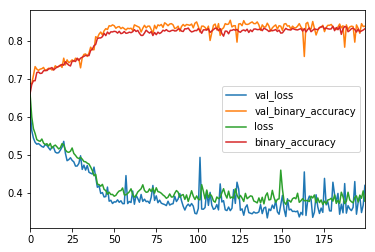

In [184]:
pd.DataFrame(history.history).plot()

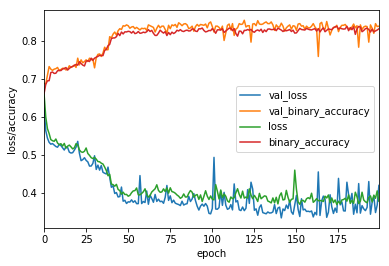

In [187]:
pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.ylabel("loss/accuracy")
plt.savefig("gru_train.png",dpi=500)

In [123]:
y_pred = model.predict(X_test)

In [124]:
y_pred

array([[1.9371510e-06],
       [7.6478708e-01],
       [5.8343220e-01],
       ...,
       [8.1118798e-01],
       [7.1525574e-07],
       [7.1967399e-01]], dtype=float32)

In [130]:
predictions = [round(value[0]) for value in y_pred]
 
# 评估预测结果
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 85.55478%


In [150]:
y_pred = model.predict(X_test)
predictions = [round(value[0]) for value in y_pred]
 
# 评估预测结果
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 83.25192%
